In [ ]:
# Perform the Box-Cox transformation
# The boxcox function requires all values to be positive
ts_df['revenue'] = ts_df['revenue'] + 1  # Add a small value to ensure positivity if needed
transformed_data, lambda_value = boxcox(ts_df['revenue'])

# Add the transformed data to the DataFrame
ts_df['revenue_boxcox'] = transformed_data

# Plot the original and transformed data
plt.figure(figsize=(12, 6))
plt.plot(ts_df.index, ts_df['revenue'], label='Original Revenue')
plt.plot(ts_df.index, ts_df['revenue_boxcox'], label='Box-Cox Transformed Revenue')
plt.title(f'Box-Cox Transformation (Lambda: {lambda_value:.2f})')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

# Display the lambda value used for the transformation
print(f'Optimal lambda for Box-Cox transformation: {lambda_value}')




# Perform the Box-Cox transformation

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import boxcox

def apply_boxcox_transformation(data, column, add_constant=1e-5):
    """
    Applies a Box-Cox transformation to a specified column in a DataFrame.

    Parameters:
        data (pd.DataFrame): The input DataFrame with a time series index.
        column (str): The column name to transform.
        add_constant (float, optional): A small value to add to ensure all values are positive.
                                        Default is 1e-5.

    Returns:
        pd.DataFrame: A new DataFrame with the original and Box-Cox transformed columns.
        float: The optimal lambda value used for the Box-Cox transformation.
    """
    # Ensure all values are positive by adding a small constant if needed
    transformed_column = data[column] + add_constant

    # Perform the Box-Cox transformation
    transformed_data, lambda_value = boxcox(transformed_column)

    # Create a new DataFrame to hold the original and transformed data
    result_df = data.copy()
    result_df[f'{column}_boxcox'] = transformed_data

    # Plot the original and transformed data using Plotly
    fig = go.Figure()

    # Add original data to the plot
    fig.add_trace(go.Scatter(x=result_df.index, y=result_df[column], mode='lines', name=f'Original {column}'))

    # Add transformed data to the plot
    fig.add_trace(go.Scatter(x=result_df.index, y=result_df[f'{column}_boxcox'], mode='lines', name=f'Box-Cox Transformed {column}'))

    # Update layout
    fig.update_layout(
        title=f'Box-Cox Transformation (Lambda: {lambda_value:.2f})',
        xaxis_title='Time',
        yaxis_title=column,
        legend_title='Series',
        template='plotly_white'
    )

    # Show the figure
    fig.show()

    # Return the new DataFrame and lambda value
    return result_df, lambda_value



# Perform the Box-Cox transformation

result, optimal_lambda = apply_boxcox_transformation(ts_df, 'revenue')
print(f'Optimal lambda for Box-Cox transformation: {optimal_lambda}')


# validate_boxcox_transformation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import levene, shapiro

def validate_boxcox_transformation(transformed_data):
    """
    Validates the Box-Cox transformation by checking for constant variance and normality.

    Parameters:
        transformed_data (pd.Series): The Box-Cox transformed data.

    Returns:
        None
    """
    # Plot histogram
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(transformed_data, bins=30, color='skyblue', edgecolor='black')
    plt.title('Histogram of Transformed Data')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    qqplot(transformed_data, line='s', ax=plt.gca())
    plt.title('Q-Q Plot of Transformed Data')
    plt.tight_layout()
    plt.show()

    # Levene's test for constant variance
    # Split data into two halves to check if variances are equal
    half = len(transformed_data) // 2
    stat, p_value = levene(transformed_data[:half], transformed_data[half:])
    print(f"Levene's test for equal variance: Statistic={stat:.4f}, p-value={p_value:.4f}")

    # Shapiro-Wilk test for normality
    stat, p_value = shapiro(transformed_data)
    print(f"Shapiro-Wilk test for normality: Statistic={stat:.4f}, p-value={p_value:.4f}")

# Example usage
# Assuming result['revenue_boxcox'] is your transformed column
validate_boxcox_transformation(result['revenue_boxcox'])


In [20]:
def plot_moving_average(df, column, window_size):
    """
    Create a plot comparing original revenue with a moving average.

    Parameters:
    df (DataFrame): DataFrame containing the revenue data with a 'revenue' column.
    window_size (int): The size of the window for the moving average calculation.

    Returns:
    None: Displays the plot.
    """
    # Calculate the moving average
    rolling_mean = df[column].rolling(window=window_size).mean()
    rolling_std = df[column].rolling(window=window_size).std()

    # Create a figure using Plotly
    fig = go.Figure()

    # Add original revenue line
    fig.add_trace(go.Scatter(x=df.index, y=df[column], mode='lines', name='Original', line=dict(color='green')))

    # Add smoothed revenue line
    fig.add_trace(go.Scatter(x=df.index, y=rolling_mean , mode='lines', name=f'{window_size}-days Moving Average', line=dict(color='red')))

    # Add smoothed revenue line
    fig.add_trace(go.Scatter(x=df.index, y=rolling_std, mode='lines', name=f'{window_size}-days Moving STD', line=dict(color='blue')))

    # Update layout with larger dimensions
    fig.update_layout(title=f'{window_size}-days Smoothed {column}' ,
                      xaxis_title='Date',
                      yaxis_title=f'{column}',
                      legend_title='Legend',
                      width=1130,  
                      height=600)  

    # Show the plot
    fig.show()

In [52]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary

import statsmodels.tsa.stattools as ts

def dftest(timeseries):
    dftest = ts.adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[1] <= 0.05 :
        print('\nData is likely stationary\n')
    else :
        print('\nData is non stationary\n')

In [54]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import MSTL

def plot_mstl_time_series_decomposition(df, column_name, periods):
    """
    Plots the time series decomposition using MSTL.
    
    Parameters:
    - ts_df: DataFrame containing the time series data
    - column_name: str, the name of the column to decompose
    - title: str, title of the plot
    - periods: tuple, the periods for MSTL decomposition
    """

    # Ensure periods is a tuple
    if isinstance(periods, (int, float)):
        periods = (periods,)
        
    # Perform MSTL decomposition
    model = MSTL(df[column_name], periods=periods)
    decomp = model.fit()

    # Create the subplots
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.05, subplot_titles=(column_name, "Trend", "Seasonal", "Residuals"))

    # Add a horizontal line at y=0 across all rows
    fig.add_hline(y=0, line_dash="dash", row='all', col=1, line_color="red")

    # Plot the original time series
    fig.add_trace(go.Scatter(x=df.index, y=df[column_name], mode='lines', name=column_name), row=1, col=1)

    # Plot the decomposed components: Trend, Seasonal, and Residuals
    fig.add_trace(go.Scatter(x=df.index, y=decomp.trend, mode='lines', name='Trend'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=decomp.seasonal, mode='lines', name='Seasonal'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df.index, y=decomp.resid, mode='markers', name='Residuals'), row=4, col=1)

    # Add a green horizontal line at y=0 for each subplot
    for i in range(1, 5):
        fig.add_shape(type='line',
                      x0=df.index.min(), x1=df.index.max(), 
                      y0=0, y1=0, 
                      line=dict(color='green', width=1.5),
                      row=i, col=1)

    # Update layout with the title and dimensions
    fig.update_layout(title=f'MSTL Decomposition of {column_name}',
                      height=800, width=1100,
                      showlegend=False,
                      xaxis=dict(title='Date'))

    # Show the plot
    fig.show()



In [38]:
import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.stattools import acf
import numpy as np

def plot_autocorrelation(df, column_name, nlags):
    """
    Plots the autocorrelation of a time series with confidence intervals.
    
    Parameters:
    - ts_df: DataFrame containing the time series data
    - column_name: str, the name of the column to compute autocorrelation for
    - nlags: int, number of lags to compute autocorrelation (default is 600)
    - conf_level: float, confidence level for the intervals (default is 3.291 for 99.9%)
    - title: str, title of the plot
    """
    # Compute autocorrelation values
    autocorr_values = acf(df[column_name], nlags=nlags)
    lags = list(range(len(autocorr_values)))

    # Calculate the confidence interval
    n = len(ts_df[column_name])
    conf_interval = 3.291 / np.sqrt(n)  # alpha equal to 0,001 and not the classic 0.05

    # Create the plot
    fig = go.Figure()

    # Plot the autocorrelation values as bars
    fig.add_trace(go.Bar(x=lags, y=autocorr_values, marker_color='blue', name='Autocorrelation'))

    # Add confidence interval lines
    fig.add_trace(go.Scatter(x=lags, y=[conf_interval] * len(lags), mode='lines', 
                             line=dict(color='red', dash='dash'), name='Upper Confidence Interval'))
    fig.add_trace(go.Scatter(x=lags, y=[-conf_interval] * len(lags), mode='lines', 
                             line=dict(color='red', dash='dash'), name='Lower Confidence Interval'))

    # Update layout
    fig.update_layout(
        title=f'Autocorrelation Plot of {column_name}',
        xaxis_title='Lag',
        yaxis_title='Autocorrelation',
        yaxis_range=[-1, 1],
        width=1100,
        height=600,
        showlegend=False
    )

    # Show the plot
    fig.show()

In [45]:
def Bartlett_test(dataframe, col_to_group_by, col_to_analyze):
    """
    Perform Bartlett's test on the specified group and value columns.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    col_to_group_by (str): The column name for grouping (e.g., 'country').
    col_to_analyze (str): The numerical column name to analyze (e.g., 'revenue').

    Returns:
    an interpretation message.
    """
    # Create a list of groups for the value column
    groups = [group[col_to_analyze].dropna() for name, group in dataframe.groupby(col_to_group_by)]
    
    # Perform Levene's test
    statistic, p_value = stats.bartlett(*groups)
    
    # Interpretation
    if p_value >= 0.05:
        print(f"\nThe variances of {col_to_analyze} across {col_to_group_by}s are approximately equal (p-value = {round(p_value,4)})\n")
    else : 
        print(f"\nThe variances of {col_to_analyze} across {col_to_group_by}s are significantly different (p-value = {round(p_value,4)})\n")
        

In [105]:
import plotly.graph_objects as go
import numpy as np
import statsmodels.api as sm
from scipy.stats import shapiro

def residuals_pacf_and_normality(model):
    """
    Plots the Partial Autocorrelation Function (PACF) of the residuals and performs the Shapiro-Wilk test for normality.

    Parameters:
    - model: A fitted SARIMAX model
    """
    # Extract the residuals from the model
    residuals = model.resid

    # Calculate PACF and confidence intervals
    pacf_values, pacf_conf = sm.tsa.pacf(residuals[model.loglikelihood_burn:], alpha=0.05, nlags=14)

    # Calculate confidence intervals for PACF
    pacf_lower_y = pacf_conf[:, 0] - pacf_values
    pacf_upper_y = pacf_conf[:, 1] - pacf_values

    # Create a Plotly figure
    fig = go.Figure()

    # Plot PACF lines
    for x in range(len(pacf_values)):
        fig.add_trace(go.Scatter(x=[x, x], y=[0, pacf_values[x]], mode='lines', line=dict(color='#3f3f3f'), showlegend=False))

    # Markers for PACF values
    fig.add_trace(go.Scatter(x=np.arange(len(pacf_values)), y=pacf_values, mode='markers', marker=dict(color='#ff7f0e', size=12), showlegend=False))

    # Add confidence interval lines
    fig.add_trace(go.Scatter(x=np.arange(len(pacf_values)), y=pacf_upper_y, mode='lines', line=dict(color='rgba(255,255,255,0)'), showlegend=False))
    fig.add_trace(go.Scatter(x=np.arange(len(pacf_values)), y=pacf_lower_y, mode='lines', line=dict(color='rgba(255,255,255,0)'), showlegend=False, 
                              fill='tonexty', fillcolor='rgba(255, 127, 14, 0.3)'))

    # Update layout
    fig.update_layout(title='Partial Autocorrelation Function (PACF) of Residuals (after burn-in)', 
                      xaxis_title='Lags', yaxis_title='', height=500, width=800)

    # Show the figure
    fig.show()

    # Perform the Shapiro-Wilk test for normality on the residuals after burn-in
    stat, p_value = shapiro(residuals[model.loglikelihood_burn:])

    # Interpret the result of the Shapiro-Wilk test
    print("\nShapiro-Wilk test\n{}".format("-"*22))
    print(f'Statistic={stat:.4f}, p-value={p_value:.4f}')
    if p_value > 0.05:
        print("\nResiduals appear to be normally distributed.\n")
    else:
        print("\nResiduals do not appear to be normally distributed.\n")


In [93]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
import statsmodels.api as sm

def plot_sarimax_diagnostics(model):
    """
    Plots diagnostics for a SARIMAX model.
    
    Parameters:
    - model: A fitted SARIMAX model
    """
    # Extract the residuals from the model
    residuals = model.resid

    # Create subplots
    fig = make_subplots(rows=2, cols=2, vertical_spacing=0.1,
                        subplot_titles=['Residuals', 'Histogram of Residuals', 'Q-Q Plot of Residuals', 'ACF of Residuals'])

    # Residuals plot
    fig.add_trace(
        go.Scatter(x=np.arange(len(residuals)), y=residuals, mode='lines', name='Residuals'),
        row=1, col=1
    )

    # Histogram of Residuals with KDE and N(0,1)
    x_vals = np.linspace(np.min(residuals), np.max(residuals), 100)
    kde = norm.pdf(x_vals, loc=np.mean(residuals), scale=np.std(residuals))  # KDE approximation

    # Add histogram
    fig.add_trace(
        go.Histogram(x=residuals, nbinsx=30, name='Histogram', histnorm='probability density'),
        row=1, col=2
    )
    
    # Add KDE line
    fig.add_trace(
        go.Scatter(x=x_vals, y=kde, mode='lines', name='KDE', line=dict(color='blue')),
        row=1, col=2
    )

    # Add standard normal distribution N(0,1)
    std_normal = norm.pdf(x_vals, loc=0, scale=1)
    fig.add_trace(
        go.Scatter(x=x_vals, y=std_normal, mode='lines', name='N(0,1)', line=dict(color='green', dash='dash')),
        row=1, col=2
    )

    # Q-Q Plot
    qq_theoretical = np.linspace(np.min(residuals), np.max(residuals), len(residuals))
    qq_sample = np.sort(residuals)
    fig.add_trace(
        go.Scatter(x=qq_theoretical, y=qq_sample, mode='markers', name='Q-Q Plot'),
        row=2, col=1
    )

    # Add diagonal line to Q-Q Plot
    fig.add_trace(
        go.Scatter(x=qq_theoretical, y=qq_theoretical, mode='lines', name='45-degree Line', line=dict(color='green', dash='dash')),
        row=2, col=1
    )

    # ACF of Residuals
    acf_values, acf_conf = sm.tsa.acf(residuals, alpha=0.05, nlags=14)
    
    # Calculate confidence intervals for ACF
    acf_lower_y = acf_conf[:, 0] - acf_values
    acf_upper_y = acf_conf[:, 1] - acf_values
    
    # Plot ACF with confidence intervals
    for x in range(len(acf_values)):
        # Vertical line for ACF values
        fig.add_trace(
            go.Scatter(x=[x, x], y=[0, acf_values[x]], mode='lines', line_color='#3f3f3f'),
            row=2, col=2
        )  
    
    # Markers for ACF values
    fig.add_trace(
        go.Scatter(x=np.arange(len(acf_values)), y=acf_values, mode='markers',
                    marker_color='#1f77b4', marker_size=12, name='ACF'),
        row=2, col=2
    )

    # Fill between the confidence intervals
    fig.add_trace(
        go.Scatter(x=np.arange(len(acf_values)), y=acf_upper_y, mode='lines', line_color='rgba(255,255,255,0)', name='Upper CI'),
        row=2, col=2
    )
    
    fig.add_trace(
        go.Scatter(x=np.arange(len(acf_values)), y=acf_lower_y, fill='tonexty', 
                    fillcolor='rgba(32, 146, 230, 0.3)', line_color='rgba(255,255,255,0)', name='Lower CI'),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        title='SARIMAX Model Diagnostics',
        height=700,
        width=1100,
        showlegend=False
    )

    # Show the plot
    fig.show()


### 1 - Importing the necessary librairies

In [1]:
## Import necessary libraries 

# Ingestion module for loading JSON data 
from ingestion_module import load_json_data
# Ingestion module for handling outliers
from ingestion_module import detect_outliers
# Ingestion module for creating a time series dataframe
from ingestion_module import time_series_df
# Ingestion module for top_revenue by country
from ingestion_module import top_revenue_by_country
# Ingestion module for plot_revenu_violin
from ingestion_module import plot_revenu_violin
# Ingestion module for normality_check
from ingestion_module import normality_check
# Ingestion module for create_anova_df
from ingestion_module import create_anova_df
# Ingestion module for levenes_test
from ingestion_module import levenes_test
# Ingestion module for welchs_anova
from ingestion_module import welchs_anova
# Ingestion module for tukeys_hsd_test
from ingestion_module import Games_Howell_test
# Ingestion module for correlation_matrix_and_stat_significance
from ingestion_module import correlation_matrix_and_stat_significance
# Ingestion module for pairplot
from ingestion_module import pairplot
# Ingestion module for plot_moving_average
from ingestion_module import plot_moving_average
# Ingestion module for plot_time_series_decomposition
from ingestion_module import plot_time_series_decomposition
# Ingestion module for acf_and_pacf_plots
from ingestion_module import acf_and_pacf_plots

# Pandas for data manipulation and analysis
import pandas as pd
# NumPy for numerical operations and array handling
import numpy as np

# SciPy for statistical functions and tests
import scipy.stats as stats  # General statistical functions
from scipy.stats import f  # f-distribution functions
from scipy.stats import t  # t-distribution functions
from scipy.stats import shapiro  # Shapiro-Wilk test for normality
from scipy.stats import levene  # Levene’s test for equal variances
from scipy.stats import ttest_ind  # Independent t-test
from scipy.stats import normaltest  # Test for normality
from scipy.stats import probplot  # Probability plot for normality assessment
from scipy.stats import spearmanr  # Spearman rank correlation coefficient
from scipy.stats import pearsonr


# Statsmodels for statistical modeling and time series analysis
import statsmodels.api as sm  # Main Statsmodels API
import statsmodels.stats.multicomp as smc
from statsmodels.stats.diagnostic import acorr_ljungbox
import prophet
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL  # Seasonal-Trend decomposition using LOESS
from statsmodels.tsa.seasonal import seasonal_decompose  # Seasonal decomposition
from statsmodels.tsa.stattools import acf, pacf  # Autocorrelation and partial autocorrelation functions
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test for stationarity
from datetime import datetime

# Scikit-learn for machine learning and model evaluation
from sklearn.model_selection import train_test_split  # Splitting data into training and test sets
from sklearn.linear_model import Ridge  # Ridge regression model
from sklearn.linear_model import RidgeCV  # Ridge regression with cross-validation
from sklearn.metrics import mean_squared_error  # MSE metric for model evaluation
# Isolation Forest for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# itertools for creating combinations of elements (useful for parameter tuning)
import itertools  

# Seaborn for data visualization with a higher-level interface
import seaborn as sns
# Matplotlib for basic plotting and visualization
import matplotlib.pyplot as plt
# Plotly for interactive visualizations
from plotly.subplots import make_subplots  # For creating subplots
import plotly.express as px  # Simplified interface for creating visualizations
import plotly.graph_objects as go  # More complex Plotly visualizations


# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')


print('\nNecessary librairies imported\n')





Necessary librairies imported



### 2 - Loading the dataframe

In [2]:
## loading the dataframe as loaded_df

loaded_df = load_json_data('cs-train')

print("\nLoading Summary\n{}".format("-"*22))

print("\n... Dataframe loaded as 'loaded_df'\n")

## Information about the data types
print('The columns are:\n',loaded_df.columns.tolist())

# List of numerical columns
numerical_cols = loaded_df.select_dtypes(include='number').columns.tolist()
print(f'\nThe numerical columns in loaded_df are : {" and ".join(numerical_cols)}\n')
# List of categorycal columns
categorycal_cols = loaded_df.select_dtypes(include='category').columns.tolist()
print(f'\nThe categorycal columns in loaded_df are : {", ".join(categorycal_cols)}\n')

## Rows count
print(f'\nloaded_df contains initialy {len(loaded_df):,.0f} rows\n')



Loading Summary
----------------------

... Dataframe loaded as 'loaded_df'

The columns are:
 ['country', 'date', 'invoice_id', 'customer_id', 'stream_id', 'times_viewed', 'price']

The numerical columns in loaded_df are : times_viewed and price


The categorycal columns in loaded_df are : country, invoice_id, customer_id, stream_id


loaded_df contains initialy 815,011 rows



### 3 - Cleaning the dataframe

#### B - Handling Duplicate Rows

In [3]:
## Check for Duplicate rows in loaded_df

duplicate_rows = loaded_df.duplicated(keep="first")
total_duplicates = duplicate_rows.sum()

print(f'\nThere are {total_duplicates:,.0f} duplicate rows\n')



There are 28,844 duplicate rows



In [4]:
# Remove the duplicate rows in loaded_df

print("\nDuplicate rows Summary\n{}".format("-"*22))

size_before_drop_duplicates = len(loaded_df)
loaded_df.drop_duplicates(keep="first", inplace=True )
size_after_drop_duplicates = len(loaded_df)

print(f"\nThe total number of rows before dropping duplicates is {size_before_drop_duplicates:,.0f}")

print(f"\n... Removed {size_before_drop_duplicates-size_after_drop_duplicates:,.0f} duplicate rows in the loaded_df.")

print(f"\nThe total number of rows after dropping duplicates is {size_after_drop_duplicates:,.0f}\n")



Duplicate rows Summary
----------------------

The total number of rows before dropping duplicates is 815,011

... Removed 28,844 duplicate rows in the loaded_df.

The total number of rows after dropping duplicates is 786,167



#### C - Data Integrity and Quality

To maintain the integrity of our data, we cannot have negative or zero values in price and times_viewed, the numerical columns.

Therefore, we will be removing any rows that contain these invalid values.

In [5]:
## Check for data Quality in the numerical columns 

loaded_df_with_price_quality_issues        = loaded_df[ (loaded_df.price<=0) ]
loaded_df_with_times_viewed_quality_issues = loaded_df[ (loaded_df.times_viewed<=0) ]

print(f"\nThere are {len(loaded_df_with_price_quality_issues):,.0f} rows with invalid price data (negative or zero values)\n")
print(f"There are {len(loaded_df_with_times_viewed_quality_issues):,.0f} rows with invalid times_viewed data (negative or zero values)\n")



There are 5,252 rows with invalid price data (negative or zero values)

There are 7,714 rows with invalid times_viewed data (negative or zero values)



In [6]:
# Excluding rows with invalid data

print("\nData quality Summary\n{}".format("-"*26))

size_before_invalid_data = len(loaded_df)
loaded_df_without_invalid_data = loaded_df[ (loaded_df.price>0) & (loaded_df.times_viewed>0) ]
size_after_invalid_data = len(loaded_df_without_invalid_data)


print(f"\nThe total number of rows before excluding invalid data is {size_before_invalid_data:,.0f}.")

print(f"\n... Removed {(size_before_invalid_data - size_after_invalid_data):,.0f} rows with invalid data in the loaded_df.")

print(f"\nThe total number of rows after excluding invalid data is {size_after_invalid_data:,.0f}.\n")




Data quality Summary
--------------------------

The total number of rows before excluding invalid data is 786,167.

... Removed 12,328 rows with invalid data in the loaded_df.

The total number of rows after excluding invalid data is 773,839.



#### D - Handling Outliers 

To ensure the accuracy and reliability of our analysis, identifying outliers is essential as these anomalies can significantly influence our results.

Therefore, by analyzing each numerical column within individual countries, we will be removing any rows that contain outliers.

We will import the detect_outliers function, which identifies outliers in a specified column of the dataframe for each country.

This function applies Z-Score, IQR, and Isolation Forest methods to the selected column within each country group.

In [7]:

## Check for outliers in the numerical columns 

# price outliers
price_outliers = detect_outliers(loaded_df_without_invalid_data, column='price',z_threshold=3, contamination=0.01)
loaded_df_with_price_outliers = loaded_df_without_invalid_data[price_outliers]

# times_viewed outliers
times_viewed_outliers = detect_outliers(loaded_df_without_invalid_data, 'times_viewed',z_threshold=3, contamination=0.01)
loaded_df_with_times_viewed_outliers = loaded_df_without_invalid_data[times_viewed_outliers]

# combined outliers
combined_outliers = price_outliers | times_viewed_outliers
loaded_df_with_combined_outliers = loaded_df_without_invalid_data[combined_outliers]

print(f"\nThere are {len(loaded_df_with_price_outliers):,} rows identified with outlier price data")
print(f"\nThere are {len(loaded_df_with_times_viewed_outliers):,} rows identified with outlier times_viewed data")
print(f"\nOverall, There are {len(loaded_df_with_combined_outliers):,} rows identified outlier data\n")


There are 53,214 rows identified with outlier price data

There are 20,968 rows identified with outlier times_viewed data

Overall, There are 73,952 rows identified outlier data



In [8]:
# Excluding rows with outliers

print("\n Outliers Summary\n{}".format("-"*26))

size_before_handling_outliers = len(loaded_df_without_invalid_data)
loaded_df_without_outliers    = loaded_df_without_invalid_data[~combined_outliers]
size_after_handling_outliers  = len(loaded_df_without_outliers)


print(f"\nThe total number of rows before excluding outliers is {size_before_handling_outliers:,.0f}.")

print(f"\n... Removed {(size_before_handling_outliers-size_after_handling_outliers):,.0f} rows with outliers in the loaded_df_without_invalid_data.")

print(f"\nThe total number of rows after excluding outliers is {size_after_handling_outliers:,.0f}.\n")



 Outliers Summary
--------------------------

The total number of rows before excluding outliers is 773,839.

... Removed 73,952 rows with outliers in the loaded_df_without_invalid_data.

The total number of rows after excluding outliers is 699,887.



# B - Data Analysis and Hypothesis Testing 


In this section, we conduct a comprehensive analysis on the revenue data to uncover significant patterns or relationships. Specifically, we will examine whether the monthly revenue from the top ten countries shows notable differences, explore the relationships between various factors influencing revenue generation, and investigate seasonal trends in revenue. 

This analysis will help validate assumptions and draw meaningful conclusions about revenue dynamics and factors that may influence them.



In [9]:
loaded_df = loaded_df_without_outliers

Let's delve into the seasonal revenue trends, which hopefuly will reveal that certain days yield significantly higher revenue than others. 

This analysis will focus on the fields of days and price. To evaluate the seasonal patterns and identify significant revenue variations across days, we will employ statistical methods such as Seasonal Decomposition of Time Series (STL) or Autocorrelation or Partial Autocorrelation (ACF/PACF). 

### 1 - Date invistigation 

To begin with, let's understand the time coverage and potential gaps in the data.

In [10]:
## Dates Span and Missing Observations

nunique_dates = loaded_df.date.nunique()

max_date = loaded_df.date.max()
min_date = loaded_df.date.min()

span_dates = (max_date -  min_date).days + 1

missing_observations = span_dates - nunique_dates

print("\nDates Summary\n{}".format("-"*23))

print(f'\nAs highlighted above, there are {nunique_dates} unique date.')

print(f'\nThe dates span a range of {span_dates} days')

print(f'\nThe dates start the {min_date} and end the {max_date}')

print(f"\nThere are {missing_observations} missing date observations.\n")


Dates Summary
-----------------------

As highlighted above, there are 495 unique date.

The dates span a range of 611 days

The dates start the 2017-11-28 and end the 2019-07-31

There are 116 missing date observations.



### 2 - Revenue Time Series Visualization

Next, we’ll visualize the Daily Revenue Over Time to identify trends, seasonal patterns, and fluctuations in revenue. This plot will help us assess the consistency of revenue generation and detect any anomalies or significant peaks and troughs across the observed period.








In [11]:
# Transform the cleaned data into a Revenue time series
ts_df = time_series_df(loaded_df, country=None)

# Time series preparation 
ts_df = ts_df[['date','revenue']]

# Set 'date' as datetime and index
ts_df['date'] = pd.to_datetime(ts_df['date'])
ts_df.set_index('date', inplace=True)


In [13]:
ts_df.head(3)

revenue
date               
2017-11-28  8291.52
2017-11-29  8114.47
2017-11-30  7475.71

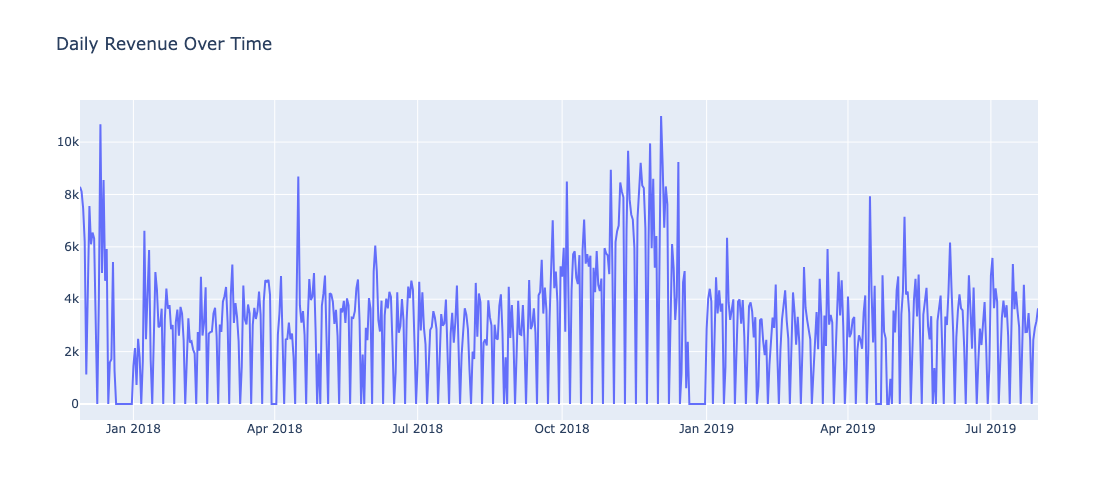

In [16]:
# Plot Revenue Time Series

fig = px.line(ts_df, x=ts_df.index, y=ts_df.revenue, title='Daily Revenue Over Time')
fig.update_layout(xaxis_title='', yaxis_title='', width=1100, height=500)
fig.show()

## Moving Average & Stationarity check

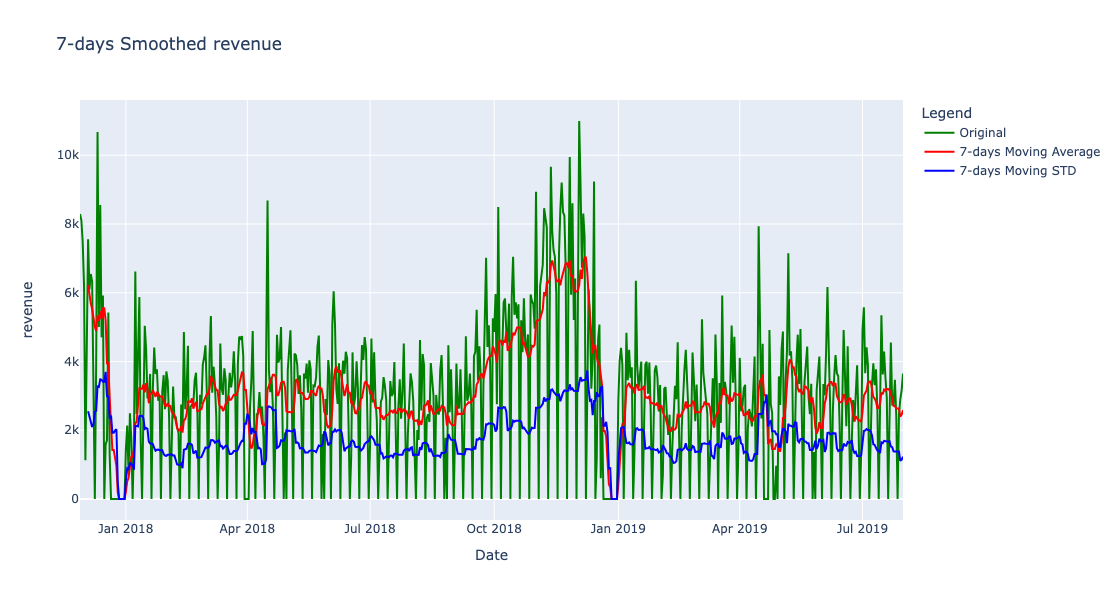

In [18]:
# Plot weekly moving average and std 

plot_moving_average(ts_df, 'revenue', 7)

In [72]:
# Create DayofWeek, WeekofYear, and quarter columns 
# to check for homogeneity of variances across the different period groups 

ts_df['year'] = ts_df.index.year
ts_df['quarter'] = ts_df.index.to_period('Q')
ts_df['month'] = ts_df.index.month
ts_df['weekofyear'] = ts_df.index.isocalendar().week
ts_df['dayofweek'] = ts_df.index.dayofweek


In [49]:
## levenes test

# check for homogeneity of variances across the different years 
levenes_test(ts_df, 'year', 'revenue')
# check for homogeneity of variances across the different quarters 
levenes_test(ts_df, 'quarter', 'revenue')
# check for homogeneity of variances across the different months 
levenes_test(ts_df, 'month', 'revenue')
# check for homogeneity of variances across the different weeks of year
levenes_test(ts_df, 'weekofyear', 'revenue')
# check for homogeneity of variances across the different days of week 
levenes_test(ts_df, 'dayofweek', 'revenue')



The variances of revenue across year are significantly different (p-value = 0.0)


The variances of revenue across quarter are significantly different (p-value = 0.0)


The variances of revenue across month are significantly different (p-value = 0.0)


The variances of revenue across weekofyear are approximately equal (p-value = 0.0543)


The variances of revenue across dayofweek are significantly different (p-value = 0.0)



In [53]:
# perform Dickey-Fuller Test on revenue

dftest(ts_df.revenue)

Test Statistic           -4.533201
p-value                   0.000171
Lags Used                16.000000
Observations Used       594.000000
Critical Value (1%)      -3.441407
Critical Value (5%)      -2.866418
Critical Value (10%)     -2.569368
dtype: float64

Data is likely stationary



## Autocorrelation Plot of Revenue

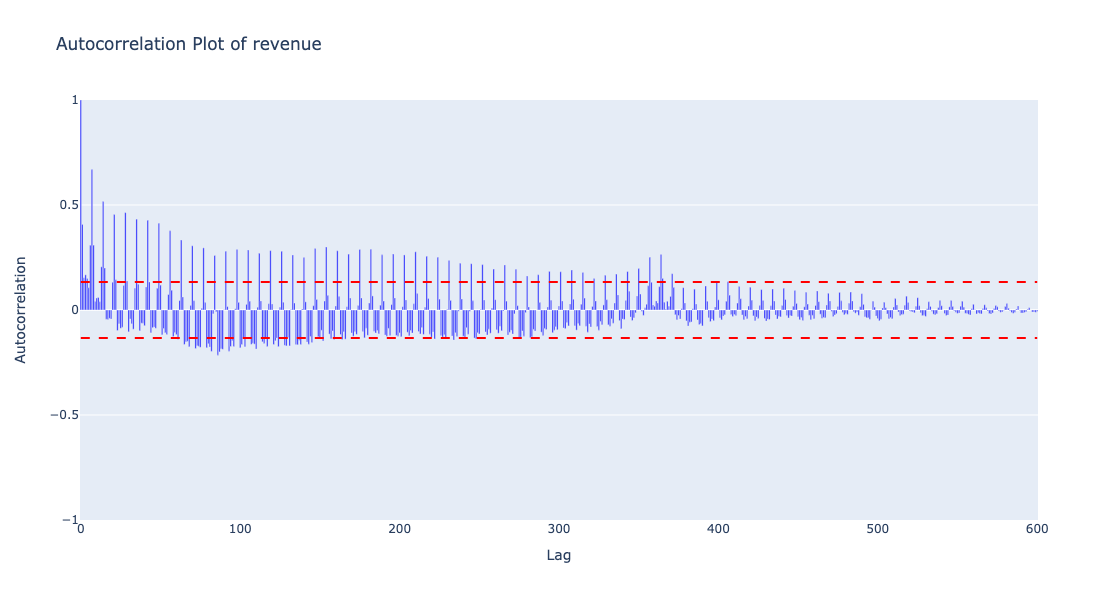

In [46]:
# plot autocorrelation

plot_autocorrelation(ts_df, 'revenue', 600)


## MSTL Decomposition of Revenue

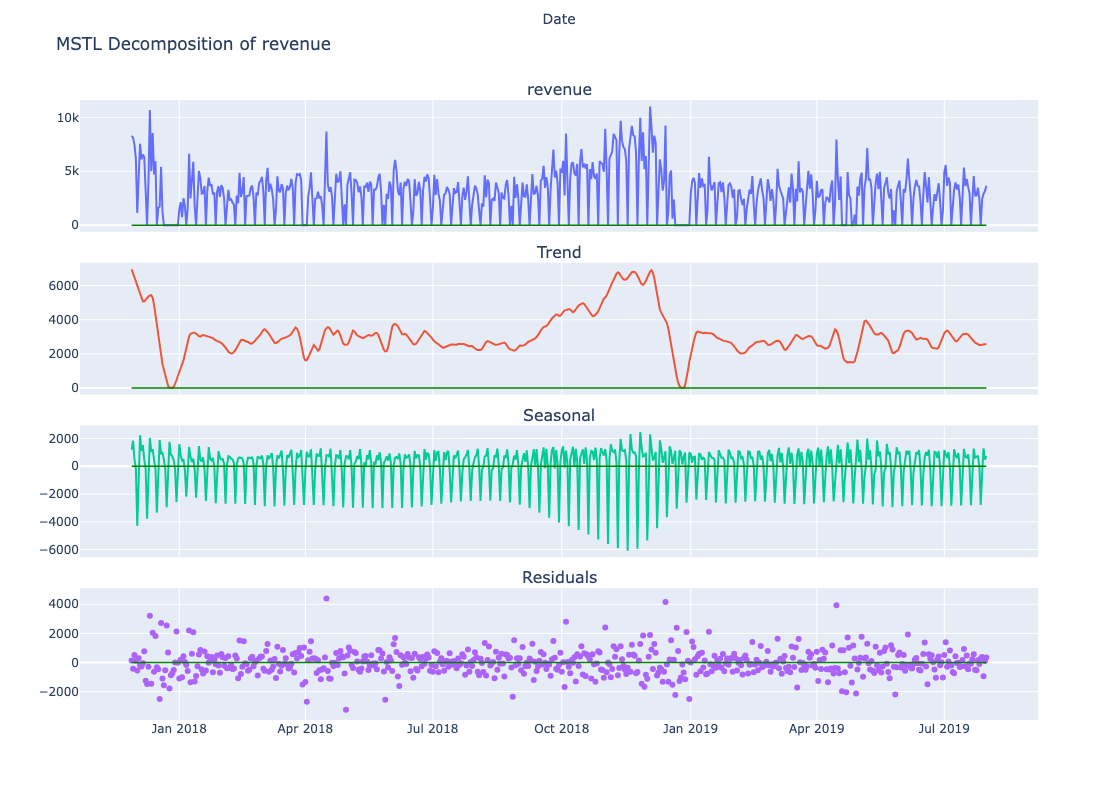

In [55]:
plot_mstl_time_series_decomposition(ts_df, 'revenue', (7, 7*54))

## ACF and PACF Plots

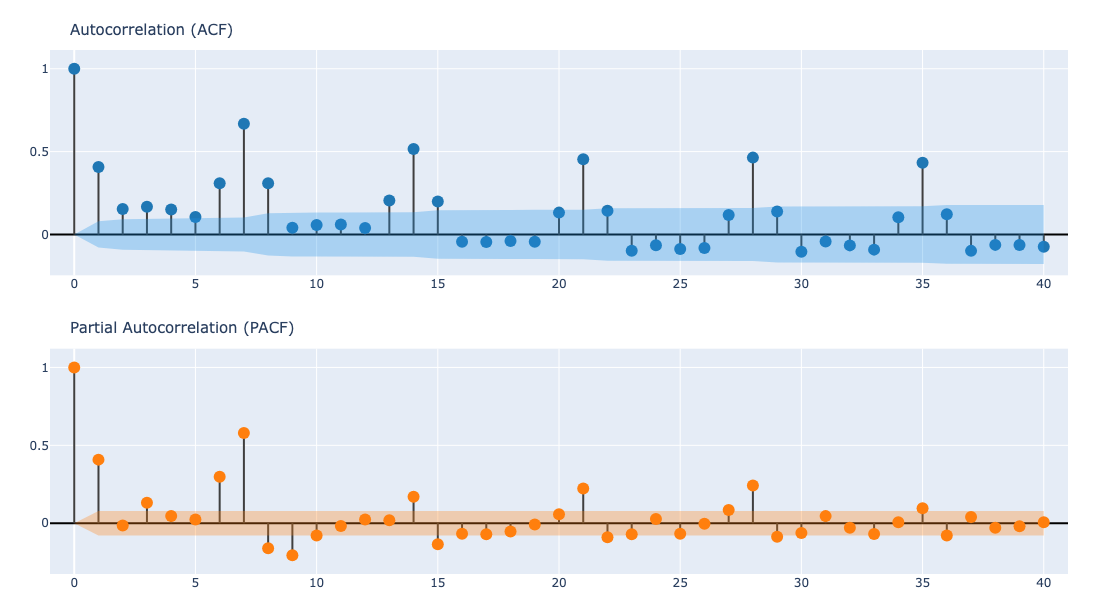

In [61]:
acf_and_pacf_plots(ts_df, 'revenue', 40)


## Revenue Time Series Transformation

In [62]:
# perform log transformation

ts_df['log_revenue'] = np.log1p(ts_df['revenue'])


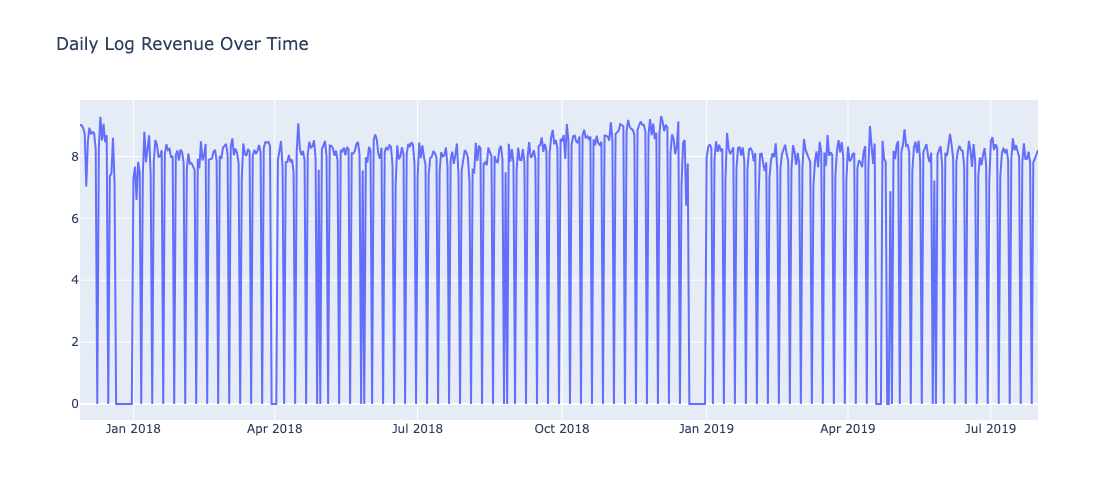

In [63]:
# Plot Log Revenue Time Series

fig = px.line(ts_df, x=ts_df.index, y=ts_df.log_revenue, title='Daily Log Revenue Over Time')
fig.update_layout(xaxis_title='', yaxis_title='', width=1100, height=500)
fig.show()

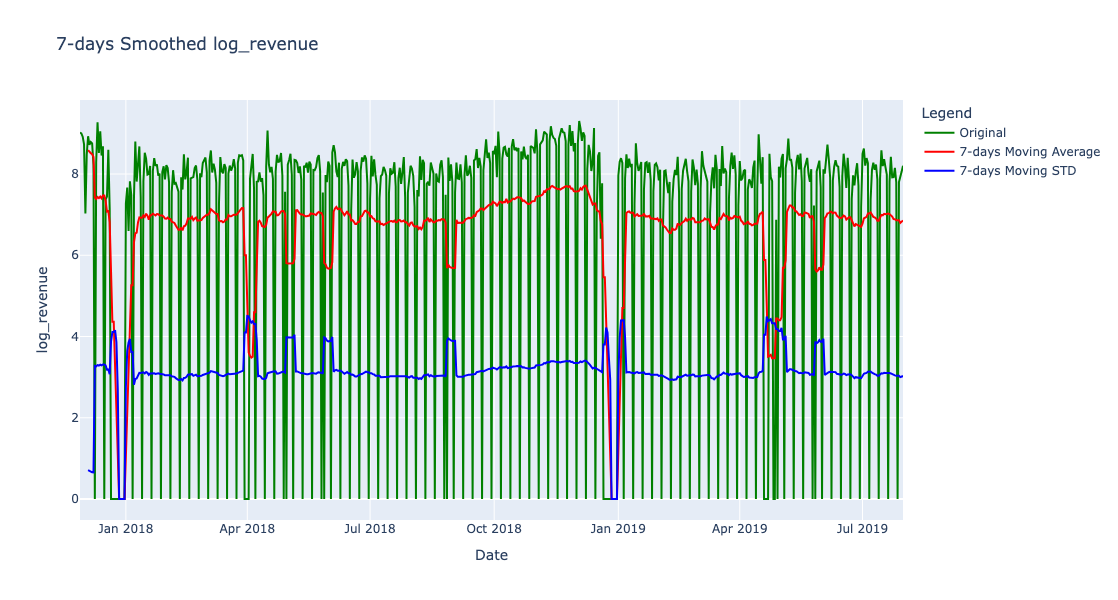

In [64]:
plot_moving_average(ts_df, 'log_revenue', 7)

In [65]:
# perform Dickey-Fuller Test on log_revenue

dftest(ts_df['log_revenue'].dropna())

Test Statistic         -6.389196e+00
p-value                 2.126643e-08
Lags Used               1.600000e+01
Observations Used       5.940000e+02
Critical Value (1%)    -3.441407e+00
Critical Value (5%)    -2.866418e+00
Critical Value (10%)   -2.569368e+00
dtype: float64

Data is likely stationary



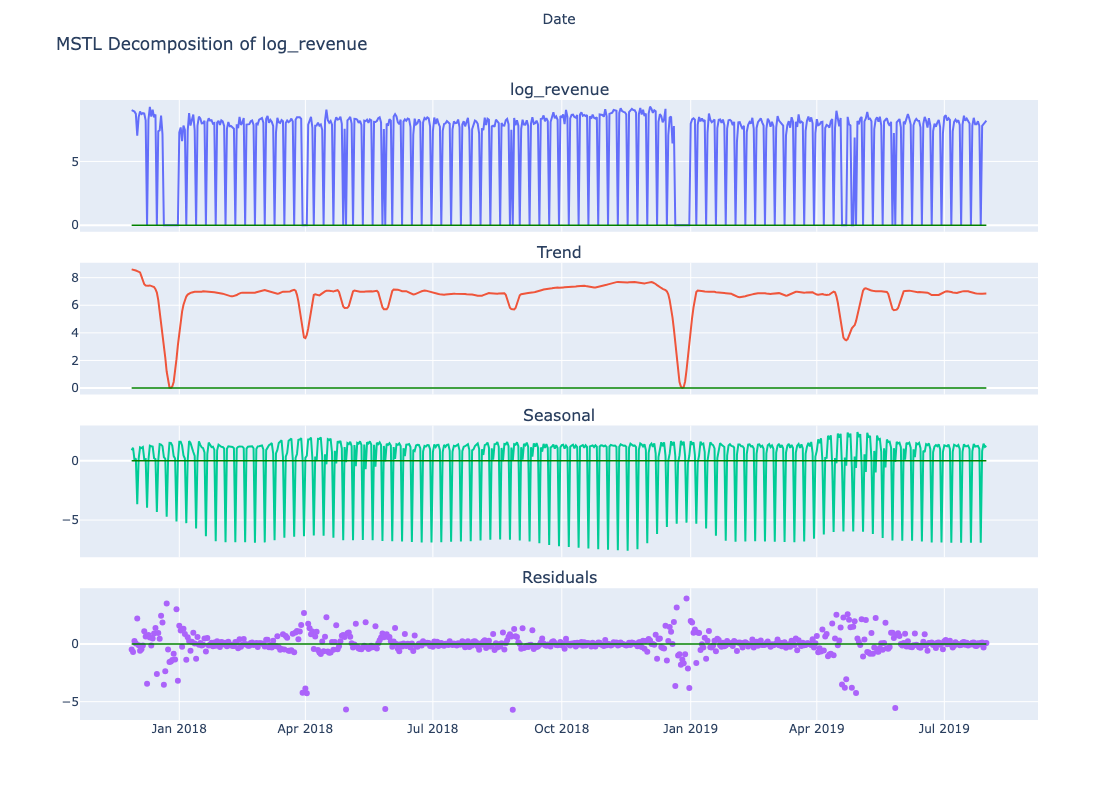

In [69]:
plot_mstl_time_series_decomposition(ts_df, 'log_revenue', (7, 7*54))

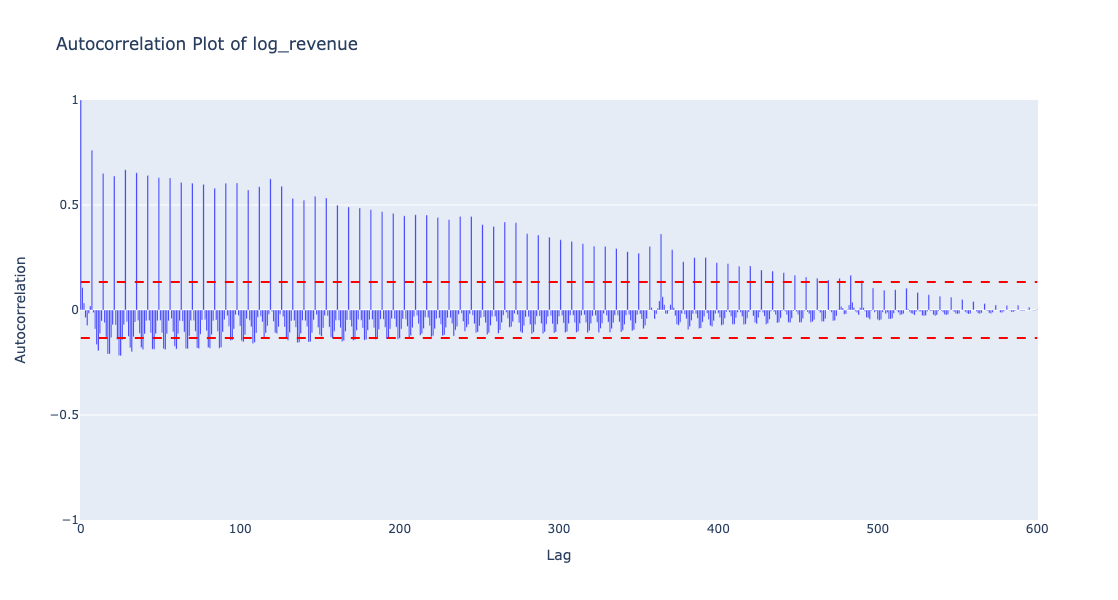

In [71]:
# plot autocorrelation

plot_autocorrelation(ts_df, 'log_revenue', 600)


In [73]:
## levenes test

# check for homogeneity of variances across the different years 
levenes_test(ts_df, 'year', 'log_revenue')
# check for homogeneity of variances across the different quarters 
levenes_test(ts_df, 'quarter', 'log_revenue')
# check for homogeneity of variances across the different months 
levenes_test(ts_df, 'month', 'log_revenue')
# check for homogeneity of variances across the different weeks of year
levenes_test(ts_df, 'weekofyear', 'log_revenue')
# check for homogeneity of variances across the different days of week 
levenes_test(ts_df, 'dayofweek', 'log_revenue')



The variances of log_revenue across year are significantly different (p-value = 0.0025)


The variances of log_revenue across quarter are significantly different (p-value = 0.0121)


The variances of log_revenue across month are significantly different (p-value = 0.0)


The variances of log_revenue across weekofyear are approximately equal (p-value = 0.9993)


The variances of log_revenue across dayofweek are significantly different (p-value = 0.0002)



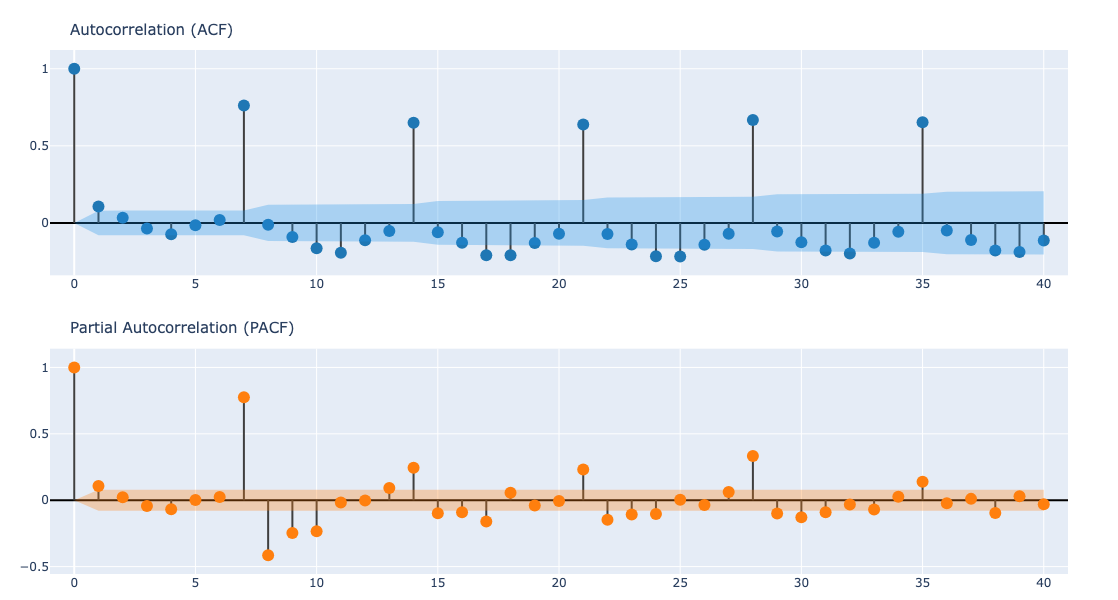

In [74]:
acf_and_pacf_plots(ts_df, 'log_revenue', 40)


In [75]:
# differencing the seasonality discovered in the plots above 

ts_df['lag_07'] = ts_df.log_revenue.shift(7)
ts_df['seasonal_diff'] = ts_df.log_revenue - ts_df['lag_07']

In [79]:
# perform Dickey-Fuller Test on seasonal_diff

dftest(ts_df['seasonal_diff'].dropna())

Test Statistic         -7.667392e+00
p-value                 1.627434e-11
Lags Used               1.900000e+01
Observations Used       5.840000e+02
Critical Value (1%)    -3.441597e+00
Critical Value (5%)    -2.866502e+00
Critical Value (10%)   -2.569412e+00
dtype: float64

Data is likely stationary



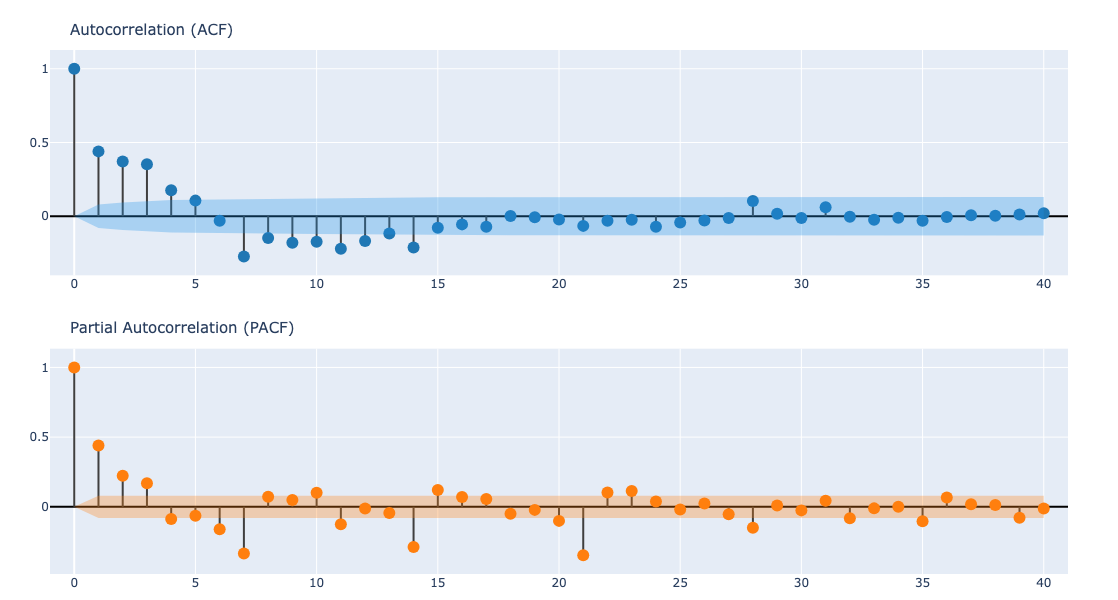

In [80]:


acf_and_pacf_plots(ts_df.dropna(), 'seasonal_diff', 40)

In [81]:
p=3
d=0
q=4

s=7

In [ ]:
# Perform a SARIMA auto modeling 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import aic
import itertools


# Define ranges for p, d, q
p = q = range(0, 5)
d=0
# Define ranges for seasonal P, D, Q, s
P = Q = range(0, 5)
D = 1
s = 7

# Store results
results = []

# Create a grid of parameters
param_combinations = list(itertools.product(p, q, P, Q))

# Loop through all combinations of (p, d, q) and (P, D, Q, s)
for p_val, q_val, P_val, Q_val in param_combinations:
    try:
        # Fit the SARIMA model
        model = SARIMAX(ts_df.log_revenue.dropna(),
                        order=(p_val, 0, q_val), 
                        seasonal_order=(P_val, 1, Q_val, 7))
        result = model.fit(disp=False)

        # Save the AIC and parameters
        results.append((p_val, 0, q_val, P_val, 1, Q_val, 7, result.aic, result.params))
        
        print(f"Fitted SARIMA({p_val}, 0, {q_val}) x ({P_val}, 1, {Q_val}, 7) - AIC: {result.aic}")
    except Exception as e:
        print(f"Error with p={p_val}, d=0, q={q_val}, P={P_val}, D=1, Q={Q_val}, s=7: {e}")


# The best model : SARIMA(4, 0, 1) x (1, 1, 2, 7) - AIC: 18.0


In [ ]:
## Determine the best model 

# sort results by AIC 
results.sort(key=lambda x: x[7])

# Determine the best model 
best_auto_model_params = results[0]
best_p, best_d, best_q = best_model_params[0], best_model_params[1], best_model_params[2]
best_P, best_D, best_Q, best_s = best_model_params[3], best_model_params[4], best_model_params[5], best_model_params[6]
best_aic = best_model_params[7]

print(f"The best model : SARIMA({best_p}, {best_d}, {best_q}) x ({best_P}, {best_D}, {best_Q}, {best_s}) - AIC: {best_aic}")

# Replacing those orders and seasonnal orders in our basic model 
best_auto_sarima_model = sm.tsa.statespace.SARIMAX(ts_df.log_revenue, 
                                                   order          = (best_p, best_d, best_q), 
                                                   seasonal_order = (best_P, best_D, best_Q, best_s) ).fit(disp=False)  


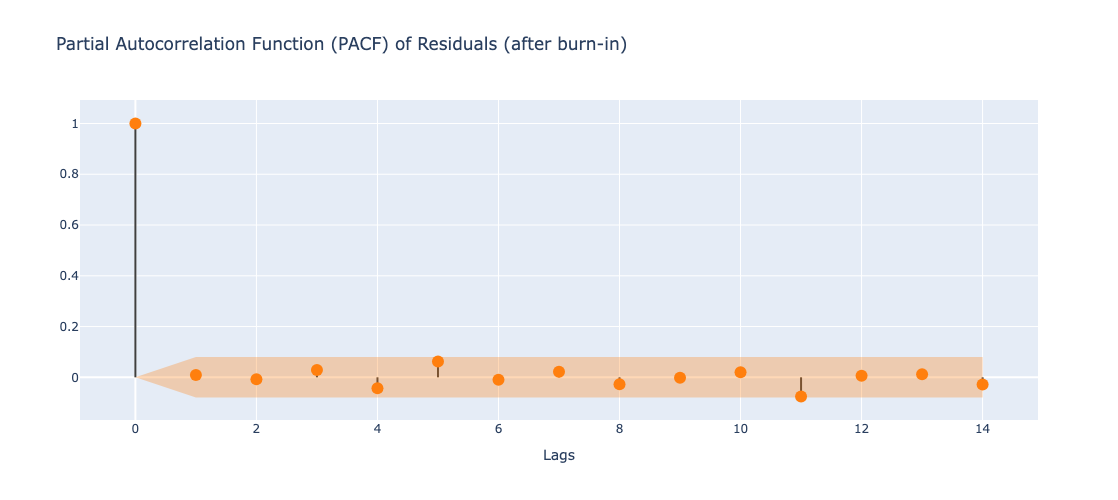


Shapiro-Wilk test
----------------------
Statistic=0.7164, p-value=0.0000

Residuals do not appear to be normally distributed.



In [104]:

residuals_pacf_and_normality(best_auto_sarima_model)


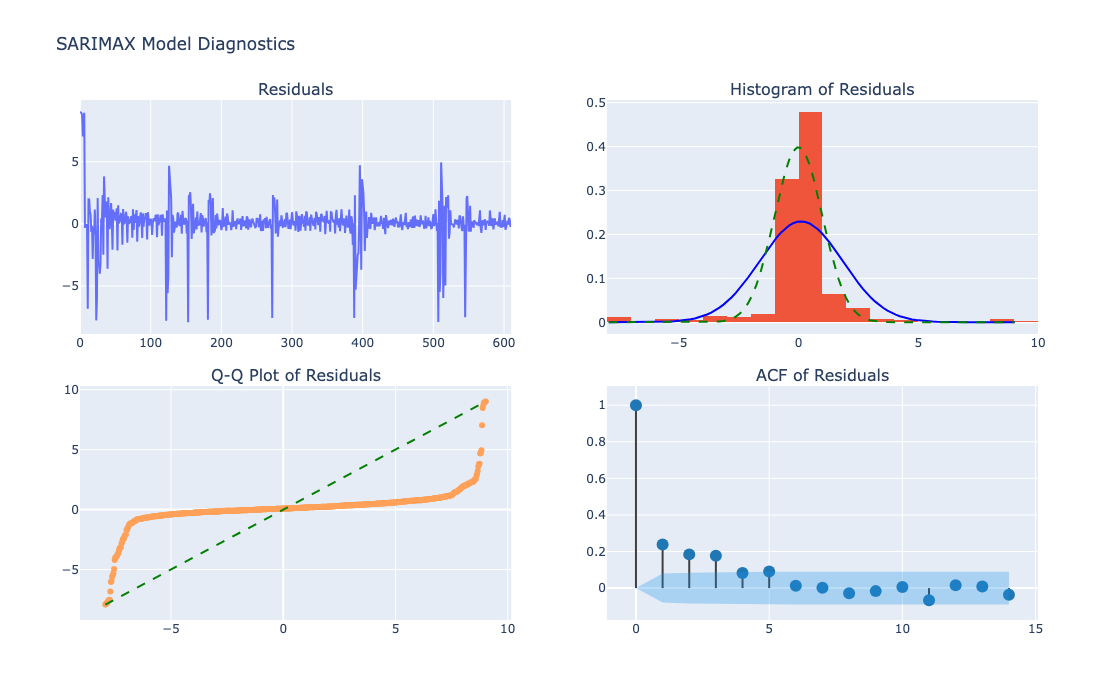

In [94]:

# Assuming 'best_auto_sarima_model' is a fitted SARIMAX model
plot_sarimax_diagnostics(best_auto_sarima_model)


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract the residuals from the model
residuals = best_auto_sarima_model.resid

# Perform the Ljung-Box test
ljungbox_results = acorr_ljungbox(residuals, lags=[14], return_df=True)

# Extract statistic and p-value
lb_stat = ljungbox_results['lb_stat'].iloc[0]
lb_pvalue = ljungbox_results['lb_pvalue'].iloc[0]

# Interpret the result of the Ljung-Box test
print("\nLjung-Box test\n{}".format("-"*22))
print(f'Statistic={lb_stat:.4f}, p-value={lb_pvalue:.4f}')
if p_value > 0.05:
    print("\nResiduals appear to be independent. The model is adequate.\n")
else:
    print("\nResiduals exhibit significant autocorrelation. The model may be inadequate.\n")



Ljung-Box test
----------------------
Statistic=88.9469, p-value=0.0000

Residuals exhibit significant autocorrelation. The model may be inadequate.



In [ ]:
# make future predictions

from dateutil.relativedelta import relativedelta

def future_preds_df(model, series, num_months):
    
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    
    return pd.DataFrame(vals,index = date_range_index)


In [ ]:
log_preds = future_preds_df(best_sarima_model, ts_df.log_revenue, 30)

plt.plot(ts_df.log_revenue)
plt.plot(log_preds)

best_sarima_model.plot_diagnostics();

print('auto-fit order: :', best_sarima_model.model.order)
print('auto-fit seasonal_order: :', best_sarima_model.model.seasonal_order)

In [ ]:
def cross_validate( series , horizon , start , step_size , order=(1,0,0) , seasonal_order=(0,0,0,0) , trend=None ):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range( start , len(series)-horizon , step_size ):
        model = sm.tsa.statespace.SARIMAX(  series[:i+1] ,                    # only using data through to and including start 
                                            order          = order, 
                                            seasonal_order = seasonal_order, 
                                            trend          = trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1])                       # forecasting horizon steps into the future
        actual.append(series[i+horizon])                                       # comparing that to actual value at that point
        date.append(series.index[i+horizon])                                   # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)



In [ ]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv): # the mean absolut percent error
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()  # the lower the best 


In [ ]:
def grid_search_ARIMA(series, horizon, start, step_size, orders, seasonal_orders, trends):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                
                cv = cross_validate(series,   # The fct defined above
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mape(cv) < best_mape :
                    best_mape           = mape(cv)
                    best_order          = order_
                    best_seasonal_order = seasonal_order_
                    best_trend          = trend_
                    cv.plot(title = f'forecast every {step_size} months using one year prior data')
                    
    return (best_order,best_seasonal_order, best_trend, best_mape)

In [ ]:
# Example Of Data for Application 
series = monthly_temp.temp
horizon = 12
start = 760
step_size = 3
orders = [(1,1,0),(1,0,0)]
seasonal_orders = [(0,1,1,12)]
trends = [None,'c']

# Application
grid_search_ARIMA(series = series,
                  horizon = horizon,
                  start = start,
                  step_size = step_size,
                  orders = orders,
                  seasonal_orders = seasonal_orders,
                  trends=trends)

# output 
#best_order , best_seasonal_order , best_trend , best_mape  & cv.plot


In [ ]:
i have a daily time series

i found in it 
- heteroscedasticity 
- trend (polynomial that i did not know the degree yet)
-  seasonality (weekly and yearly)
- autocorrelation 